# Infomation


1.   random seed - 9
2.   last acc - 93.95
3.   epoch - 100
4.   batch_size - 128


conv64(3x3) - bn - relu - maxpool(2x2) - dropout(0.3) -

conv64(3x3) - bn - relu - maxppol(2x2) - dropout(0.3) -

affine(256) - bn - relu  - dropout(0.3) -

affine (64)- bn - relu  - dropout(0.3) -

affine(10) - softmax

2 ensemble model



#####풀잎 3기 / 딥러닝 설레는 첫만남 - 김선호 








# 0. Instal Cupy

colab 환경이 아닐 경우, 아래 코드를 주석 처리 하고 개별 설치 필요

In [1]:
#@title
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


# Step 1 - import module

In [2]:
# coding: utf-8
import pickle
import cupy as cp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Step 2 - define functions

In [3]:

# define def
def identify_function(x):
    return x

def step_function(x):
    return cp.array(x > 0, dtype=cp.int)

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return cp.maximum(0, x)

def relu_grad(x):
    grad = cp.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - cp.max(x, axis=0)
        y = cp.exp(x) / cp.sum(cp.exp(x), axis=0)
        return y.T 

    x = x - cp.max(x) # 오버플로 대책
    return cp.exp(x) / cp.sum(cp.exp(x))

def mean_squared_error(y, t):
    return 0.5 * cp.sum((y-t)**2)

# def cross_entropy_error(y, t):
#     delta = 1e-7
#     return -1 * cp.sum(t * cp.log(y + delta))
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -cp.sum(cp.log(y[cp.arange(batch_size), t] + 1e-7)) / batch_size
    
def softmax_loss(x,t):
    y = softmax(x)
    return cross_entropy_error(y, t)

def im2col(icput_data, filter_h, filter_w, stride=1, pad=0):
    
    N, C, H, W = icput_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = cp.pad(icput_data, [(0,0), (0,0), (pad, pad), (pad,pad)], 'constant')
    col = cp.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, icput_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = icput_shape
    out_h = (H + 2*pad - filter_h)//stride+1
    out_w = (W + 2*pad - filter_w)//stride+1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = cp.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride -1))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] = col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

def numerical_gradient(f, x):
    h = 1e-4
    grad = cp.zeros_like(x)

    it = cp.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val
        it.iternext()

    return grad

# Step 3 - define optimizer
adam

In [4]:
# define optimizer
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = cp.zeros_like(val)
                self.v[key] = cp.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * cp.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (cp.sqrt(self.v[key]) + 1e-8)

# step 4 - define layer
relu, convolution, pooling, affine

In [5]:
# define layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
      
class LeakyRelu:
    def __init__(self, alpha=0.3):
        self.mask = None
        self.alpha = alpha
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = out[self.mask] * self.alpha
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = dout[self.mask] * self.alpha
        dx = dout
        
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None

        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape # 텐서 대책이란?
        x = x.reshape(x.shape[0], -1) # reshape에서 -1의 의미는?
        self.x = x
       
        out = cp.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = cp.dot(dout, self.W.T)
        self.dW = cp.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape) #입력 데이터 모양 변경 이유? 텐서 대응 how?
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[cp.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # for backward
        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = cp.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = cp.sum(dout, axis=0)
        self.dW = cp.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = cp.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = cp.argmax(col, axis=1)
        out = cp.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = cp.zeros((dout.size, pool_size))
        dmax[cp.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx
      
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = cp.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
    
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.icput_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.icput_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.icput_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = cp.zeros(D)
            self.running_var = cp.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = cp.mean(xc**2, axis=0)
            std = cp.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((cp.sqrt(self.running_var + 10e-7)))
        
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.icput_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = cp.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -cp.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = cp.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
# class ResRelu:
#     def __init__(self, conv1, conv2, res, beforeRes=None):
#         self.conv1 = conv1
#         self.conv2 = conv2
#         self.res = res
#         self.beforeRes = beforRes
#         self.layers = []
        
#     def forward(self):
#         conv1.

# Step 5- define trainer

In [6]:
# define trainer
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='adam', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True, name="PPNet"):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
        self.name = name

        # optimzer
        optimizer_class_dict = {'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size // mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        
        # custom
        self.start_time = time.time()

    def train_step(self, i, max_iter):
        start_time_each = time.time()
           
        batch_mask = cp.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose:
            end_time_each = time.time() - start_time_each
            infoStr = '=== max_iter:' + str(max_iter) + ' / ' +str(round(i/max_iter*100, 2)) + '%' + '       '  + 'train loss:' + str(loss) +'         time:' + str(int(end_time_each)) + ' seconds' 
            print(infoStr, end='\r')
          
        
        if self.current_iter % self.iter_per_epoch == 0:  
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose:
                end_time = time.time() - self.start_time
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + ', train loss:' + str(loss) + ", time :" + str(int(end_time)) + ' seconds  ===')
                self.start_time = time.time()
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step(i, self.max_iter)
         
        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== " + self.name +" Test Accuracy ===============")
            print("test acc:" + str(test_acc))

# Step 6 - define PPNet

In [7]:
class PPNet:
    """
      conv - relu - conv - relu - batch - dropout
      conv - relu - conv - relu - pooling - dropout
      conv - relu - conv - relu - batch - dropout
      conv - relu - conv - relu - conv - relu - pooling - 
      affine - leakyrelu - batch - dropout -
      affine - leakyrelu - batch - dropout -
      affine - softmax
    """
  
  
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=256, output_size=10, weight_init_std=0.01, weight_decay_lambda = 0):
      
        # 가중치 초기화
        self.weight_decay_lambda = weight_decay_lambda
        
        conv_output_1 = (input_dim[1] - conv_param_1['filter_size'] + 2*conv_param_1['pad']) / conv_param_1['stride'] + 1
        pool_output_1 = conv_output_1 / 2

        conv_output_2 = (pool_output_1 - conv_param_2['filter_size'] + 2*conv_param_2['pad']) / conv_param_2['stride'] + 1
        pool_output_2 = conv_output_2 / 2
        
 
       
        

        pre_node_nums = [
            input_dim[0] * conv_param_1['filter_size'] * conv_param_1['filter_size'],
            conv_param_1['filter_num'] * int(pool_output_1) * int(pool_output_1),
            conv_param_2['filter_num'] * int(pool_output_2) * int(pool_output_2),
            hidden_size,
            64,
        ]
        
        print(pre_node_nums)
        
                
        if weight_init_std == 'he':
            forHe = np.array(pre_node_nums)
            weight_init_scales = np.sqrt(2.0 / forHe) # he 초기값
            weight_init_scales = cp.array(weight_init_scales)
            #초기 가중치 조절
            weight_init_scales[0] /= 10
        
        else:
            length = len(pre_node_nums)
            weight_init_scales = cp.full(length, weight_init_std)
          
                
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2]):
          if weight_init_std == 'he':
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * cp.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
          else:
            self.params['W' + str(idx+1)] = weight_init_std * cp.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
  
          self.params['b' + str(idx+1)] = cp.zeros(conv_param['filter_num'])
          pre_channel_num = conv_param['filter_num']
        
        cnnCount = idx+1
        affineCount = cnnCount+1
        
        self.params['W' + str(affineCount)] = weight_init_scales[affineCount-1] * cp.random.randn(pre_node_nums[affineCount-1], 256)
        self.params['b' + str(affineCount)] = cp.zeros(256) 
        
        self.params['W' + str(affineCount+1)] = weight_init_scales[affineCount] * cp.random.randn(256, 64)
        self.params['b' + str(affineCount+1)] = cp.zeros(64)    
        
        self.params['W' + str(affineCount+2)] = weight_init_scales[affineCount+1] * cp.random.randn(64, output_size)
        self.params['b' + str(affineCount+2)] = cp.zeros(output_size)
        
        self.params['gamma1'] = cp.ones(conv_param_1['filter_num'] * int(conv_output_1) * int(conv_output_1))
        self.params['beta1'] = cp.zeros(conv_param_1['filter_num'] * int(conv_output_1) * int(conv_output_1))
        self.params['gamma2'] = cp.ones(conv_param_2['filter_num'] * int(conv_output_2) * int(conv_output_2))
        self.params['beta2'] = cp.zeros(conv_param_2['filter_num'] * int(conv_output_2) * int(conv_output_2))
        self.params['gamma3'] = cp.ones(256)
        self.params['beta3'] = cp.zeros(256)
        self.params['gamma4'] = cp.ones(64)
        self.params['beta4'] = cp.zeros(64)


        # 계층 생성
        self.layers = []

        self.layers.append(Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(BatchNormalization(self.params['gamma1'], self.params['beta1']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Dropout(0.3))
        
        
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(BatchNormalization(self.params['gamma2'], self.params['beta2']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Dropout(0.3))
                 
        self.layers.append(Affine(self.params['W' + str(affineCount)], self.params['b' + str(affineCount)])) 
        self.layers.append(BatchNormalization(self.params['gamma3'], self.params['beta3']))
        self.layers.append(Relu()) 
        self.layers.append(Dropout(0.3))
        
        self.layers.append(Affine(self.params['W' + str(affineCount+1)], self.params['b' + str(affineCount+1)]))
        self.layers.append(BatchNormalization(self.params['gamma4'], self.params['beta4']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.3))
        
        self.layers.append(Affine(self.params['W' + str(affineCount+2)], self.params['b' + str(affineCount+2)])) 
        self.last_layer = SoftmaxWithLoss() 
        
        self.targetLayer = []
        self.targetCount = 0
        
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Convolution) | isinstance(layer, Affine): 
                self.targetLayer.append(i)
                self.targetCount += 1
            elif isinstance(layer, BatchNormalization):
                self.targetLayer.append(str(i))
                self.targetCount += 1

    def predict(self, x, train_flg=True):
        for layer in self.layers:
          if isinstance(layer, Dropout) | isinstance(layer, BatchNormalization):
            x = layer.forward(x, train_flg)
          else:
            x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=True):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)
        weight_decay = 0
        normalIdx = 0
        for idx in self.targetLayer:
            if type(idx) == int:
              normalIdx += 1
              W = self.params['W' + str(normalIdx)]
              weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = cp.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = cp.argmax(y, axis=1)
            acc += cp.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        
        normalIdx = 0
        batchIdx = 0
        for layer_idx in self.targetLayer:
            if type(layer_idx) == int:
                normalIdx += 1
                grads['W' + str(normalIdx)] = numerical_gradient(loss_w, self.params['W' + str(normalIdx)])
                grads['b' + str(normalIdx)] = numerical_gradient(loss_w, self.params['b' + str(normalIdx)])
            elif type(layer_idx) == str:
                batchIdx += 1
                grads['gamma' + str(batchIdx)] = numerical_gradient(loss_w, self.params['gamma' + str(batchIdx)])
                grads['beta' + str(batchIdx)] = numerical_gradient(loss_w, self.params['beta' + str(batchIdx)])
        
        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        
        normalIdx = 0
        batchIdx = 0
                
        for layer_idx in self.targetLayer:
            if type(layer_idx) == int:
                normalIdx += 1
                grads['W' + str(normalIdx)] = self.layers[layer_idx].dW + self.weight_decay_lambda * self.params['W' + str(normalIdx)]
                grads['b' + str(normalIdx)] = self.layers[layer_idx].db
            elif type(layer_idx) == str:
                batchIdx += 1
                grads['gamma' + str(batchIdx)] = self.layers[int(layer_idx)].dgamma
                grads['beta' + str(batchIdx)] = self.layers[int(layer_idx)].dbeta
       
            
        return grads


    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
      
        normalIdx = 0
        batchIdx = 0
        for layer_idx in enumerate(self.targetLayer):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]
            
        for layer_idx in self.targetLayer:
            if type(layer_idx) == int:
                normalIdx += 1
                self.layers[layer_idx].W = self.params['W' + str(normalIdx)]
                self.layers[layer_idx].b = self.params['b' + str(normalIdx)]
            elif type(layer_idx) == str:
                batchIdx += 1
                self.layers[int(layer_idx)].dgamma = self.params['dgamma' + str(batchIdx)]
                self.layers[int(layer_idx)].dbeta = self.params['dbeta' + str(batchIdx)]
            

# Step 7 - execute code

In [9]:
# randomSeed
cp.random.seed(9)
np.random.seed(9)

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.fashion_mnist.load_data()

t_train = Augmentor.Pipeline.categorical_labels(t_train)
t_test = Augmentor.Pipeline.categorical_labels(t_test)

x_train= np.expand_dims(x_train,axis=1)
x_test= np.expand_dims(x_test,axis=1)


# 0-1로 정규화
x_train = (x_train.astype(cp.float32))/255
x_test = (x_test.astype(cp.float32))/255

# cp 변환
x_train = cp.array(x_train)
x_test = cp.array(x_test)
t_train = cp.array(t_train)
t_test = cp.array(t_test)

max_epochs = 100
batch_size = 128

network = PPNet(input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=256, output_size=10, weight_init_std='he', weight_decay_lambda = 1e-6)              
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=batch_size,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=10000, name="train1model")

network2 = PPNet(input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=256, output_size=10, weight_init_std='he', weight_decay_lambda = 1e-6)    

trainer2 = Trainer(network2, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=batch_size,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=10000,  name="train2model")


# 시간 체크
start_time = time.time()
trainer.train()
trainer2.train()


# 체크 종료
end_time = time.time() - start_time
print("PPNet took for % seconds" % end_time)

# 매개변수 보관
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 매개변수 보관
network2.save_params("params2.pkl")
print("Saved Network Parameters!")


[9, 12544, 3136, 256, 64]
[9, 12544, 3136, 256, 64]
=== epoch:1, train acc:0.145, test acc:0.1413, train loss:2.101812607323096, time :11 seconds  ===
=== epoch:2, train acc:0.8986, test acc:0.8873, train loss:0.46810909247308197, time :136 seconds  ===


=== epoch:3, train acc:0.9118, test acc:0.8965, train loss:0.2669435785330751, time :137 seconds  ===
=== epoch:4, train acc:0.9215, test acc:0.9049, train loss:0.3049719840951049, time :136 seconds  ===


=== epoch:5, train acc:0.9244, test acc:0.9069, train loss:0.32037658037719596, time :136 seconds  ===
=== epoch:6, train acc:0.9317, test acc:0.9124, train loss:0.2658658362057627, time :136 seconds  ===


=== epoch:7, train acc:0.9343, test acc:0.913, train loss:0.240373029543633, time :136 seconds  ===
=== epoch:8, train acc:0.9356, test acc:0.9128, train loss:0.3265792990415064, time :136 seconds  ===


=== epoch:9, train acc:0.9373, test acc:0.9154, train loss:0.22980286420015497, time :136 seconds  ===
=== epoch:10, train acc:0.9439, test acc:0.9186, train loss:0.14797412629633808, time :136 seconds  ===


=== epoch:11, train acc:0.9459, test acc:0.9191, train loss:0.17093622298119243, time :136 seconds  ===
=== epoch:12, train acc:0.9451, test acc:0.9232, train loss:0.2581074006515009, time :136 seconds  ===


=== epoch:13, train acc:0.9484, test acc:0.9217, train loss:0.21306079601833447, time :136 seconds  ===
=== epoch:14, train acc:0.9496, test acc:0.9228, train loss:0.1627567422300157, time :136 seconds  ===


=== epoch:15, train acc:0.9535, test acc:0.9227, train loss:0.18104395399763273, time :136 seconds  ===
=== epoch:16, train acc:0.9561, test acc:0.9248, train loss:0.2460755937197586, time :136 seconds  ===


=== epoch:17, train acc:0.9563, test acc:0.9259, train loss:0.17300098615204454, time :136 seconds  ===
=== epoch:18, train acc:0.9571, test acc:0.9266, train loss:0.23204054756048906, time :136 seconds  ===


=== epoch:19, train acc:0.9582, test acc:0.9266, train loss:0.17793883950848674, time :136 seconds  ===
=== epoch:20, train acc:0.9601, test acc:0.926, train loss:0.10675235548607988, time :136 seconds  ===


=== epoch:21, train acc:0.96, test acc:0.9252, train loss:0.1764654008682587, time :136 seconds  ===
=== epoch:22, train acc:0.9606, test acc:0.9253, train loss:0.13232634516522232, time :136 seconds  ===


=== epoch:23, train acc:0.9636, test acc:0.9271, train loss:0.18124706386406758, time :137 seconds  ===
=== epoch:24, train acc:0.9659, test acc:0.9287, train loss:0.21665762519229723, time :136 seconds  ===


=== epoch:25, train acc:0.964, test acc:0.9248, train loss:0.09854610114716301, time :136 seconds  ===
=== epoch:26, train acc:0.9687, test acc:0.9292, train loss:0.2952923205342935, time :136 seconds  ===


=== epoch:27, train acc:0.9702, test acc:0.9307, train loss:0.1254295298023292, time :136 seconds  ===
=== epoch:28, train acc:0.9716, test acc:0.9323, train loss:0.12079672894102284, time :136 seconds  ===


=== epoch:29, train acc:0.9699, test acc:0.9273, train loss:0.3404042196334264, time :136 seconds  ===
=== epoch:30, train acc:0.9724, test acc:0.9301, train loss:0.08026574903095565, time :136 seconds  ===


=== epoch:31, train acc:0.9713, test acc:0.9305, train loss:0.15305061097108613, time :136 seconds  ===
=== epoch:32, train acc:0.9754, test acc:0.931, train loss:0.13506238093170897, time :136 seconds  ===


=== epoch:33, train acc:0.9763, test acc:0.9326, train loss:0.17352743582820485, time :136 seconds  ===
=== epoch:34, train acc:0.9751, test acc:0.9318, train loss:0.16089488242227612, time :136 seconds  ===


=== epoch:35, train acc:0.9744, test acc:0.9323, train loss:0.171557252272667, time :136 seconds  ===
=== epoch:36, train acc:0.9775, test acc:0.9326, train loss:0.1353937278082169, time :136 seconds  ===


=== epoch:37, train acc:0.9749, test acc:0.9337, train loss:0.12217534749360529, time :136 seconds  ===
=== epoch:38, train acc:0.9782, test acc:0.9321, train loss:0.19035749208507052, time :136 seconds  ===


=== epoch:39, train acc:0.9786, test acc:0.9323, train loss:0.13530769636513662, time :136 seconds  ===
=== epoch:40, train acc:0.979, test acc:0.9331, train loss:0.10976087412281223, time :136 seconds  ===


=== epoch:41, train acc:0.9804, test acc:0.9319, train loss:0.09282534530181309, time :136 seconds  ===
=== epoch:42, train acc:0.9771, test acc:0.9305, train loss:0.11893083998437363, time :136 seconds  ===


=== epoch:43, train acc:0.984, test acc:0.9321, train loss:0.17970768023908204, time :136 seconds  ===
=== epoch:44, train acc:0.9827, test acc:0.9348, train loss:0.09966413446766831, time :136 seconds  ===


=== epoch:45, train acc:0.983, test acc:0.9355, train loss:0.14025182654806484, time :136 seconds  ===
=== epoch:46, train acc:0.9842, test acc:0.9327, train loss:0.07842770488874053, time :136 seconds  ===


=== epoch:47, train acc:0.9836, test acc:0.9334, train loss:0.13165719683540275, time :136 seconds  ===
=== epoch:48, train acc:0.9819, test acc:0.9317, train loss:0.10576348435906834, time :136 seconds  ===


=== epoch:49, train acc:0.9844, test acc:0.9343, train loss:0.08715657996147161, time :136 seconds  ===
=== epoch:50, train acc:0.9848, test acc:0.9315, train loss:0.18489687115070633, time :136 seconds  ===


=== epoch:51, train acc:0.9861, test acc:0.9337, train loss:0.17866605234680943, time :136 seconds  ===
=== epoch:52, train acc:0.986, test acc:0.9348, train loss:0.060822366623299505, time :136 seconds  ===


=== epoch:53, train acc:0.9845, test acc:0.9321, train loss:0.07030936390616489, time :136 seconds  ===
=== epoch:54, train acc:0.9872, test acc:0.9351, train loss:0.1948298090076566, time :136 seconds  ===


=== epoch:55, train acc:0.9863, test acc:0.9317, train loss:0.1433579326704384, time :136 seconds  ===
=== epoch:56, train acc:0.9867, test acc:0.9343, train loss:0.1095616183366604, time :136 seconds  ===


=== epoch:57, train acc:0.9867, test acc:0.9322, train loss:0.08441906394096735, time :136 seconds  ===
=== epoch:58, train acc:0.9878, test acc:0.9343, train loss:0.1407181844547134, time :136 seconds  ===


=== epoch:59, train acc:0.9879, test acc:0.9346, train loss:0.12958483214516273, time :136 seconds  ===
=== epoch:60, train acc:0.9877, test acc:0.9353, train loss:0.07144888859409035, time :136 seconds  ===


=== epoch:61, train acc:0.9897, test acc:0.9338, train loss:0.1827086516437132, time :135 seconds  ===
=== epoch:62, train acc:0.9894, test acc:0.9344, train loss:0.08019454445522581, time :136 seconds  ===


=== epoch:63, train acc:0.9883, test acc:0.9346, train loss:0.09050537912427359, time :136 seconds  ===
=== epoch:64, train acc:0.9884, test acc:0.9307, train loss:0.14177838332500695, time :135 seconds  ===


=== epoch:65, train acc:0.9893, test acc:0.9346, train loss:0.07169266383541027, time :136 seconds  ===
=== epoch:66, train acc:0.9914, test acc:0.932, train loss:0.0854521384961914, time :136 seconds  ===


=== epoch:67, train acc:0.9923, test acc:0.9344, train loss:0.16086578674925217, time :136 seconds  ===
=== epoch:68, train acc:0.9915, test acc:0.9334, train loss:0.06439318256600302, time :136 seconds  ===


=== epoch:69, train acc:0.9916, test acc:0.9333, train loss:0.09673969020013724, time :136 seconds  ===
=== epoch:70, train acc:0.9905, test acc:0.9326, train loss:0.1027768552907941, time :136 seconds  ===


=== epoch:71, train acc:0.9911, test acc:0.9332, train loss:0.0888384666291592, time :136 seconds  ===
=== epoch:72, train acc:0.989, test acc:0.9283, train loss:0.10159782576737521, time :136 seconds  ===


=== epoch:73, train acc:0.9891, test acc:0.9287, train loss:0.07531802088743153, time :136 seconds  ===
=== epoch:74, train acc:0.9907, test acc:0.9345, train loss:0.11037417028100574, time :136 seconds  ===


=== epoch:75, train acc:0.9917, test acc:0.9342, train loss:0.10412652956439514, time :136 seconds  ===
=== epoch:76, train acc:0.9924, test acc:0.933, train loss:0.07122456832650881, time :136 seconds  ===


=== epoch:77, train acc:0.9921, test acc:0.9354, train loss:0.07688495914237349, time :136 seconds  ===
=== epoch:78, train acc:0.9919, test acc:0.9345, train loss:0.10813693502633956, time :136 seconds  ===


=== epoch:79, train acc:0.9934, test acc:0.9349, train loss:0.0880133098976224, time :136 seconds  ===
=== epoch:80, train acc:0.9937, test acc:0.934, train loss:0.1226164349104879, time :136 seconds  ===


=== epoch:81, train acc:0.9931, test acc:0.9341, train loss:0.07020025086190962, time :136 seconds  ===
=== epoch:82, train acc:0.9946, test acc:0.9352, train loss:0.11527177835013942, time :136 seconds  ===


=== epoch:83, train acc:0.9948, test acc:0.9356, train loss:0.16361007118167098, time :136 seconds  ===
=== epoch:84, train acc:0.9941, test acc:0.9335, train loss:0.07129124047790232, time :136 seconds  ===


=== epoch:85, train acc:0.9943, test acc:0.9339, train loss:0.05637533904111158, time :136 seconds  ===
=== epoch:86, train acc:0.9945, test acc:0.9358, train loss:0.06815014557670675, time :136 seconds  ===


=== epoch:87, train acc:0.9944, test acc:0.934, train loss:0.14455251046887388, time :136 seconds  ===
=== epoch:88, train acc:0.9937, test acc:0.9337, train loss:0.07602449978962955, time :136 seconds  ===


=== epoch:89, train acc:0.9955, test acc:0.9343, train loss:0.10838821293618751, time :136 seconds  ===
=== epoch:90, train acc:0.9946, test acc:0.9312, train loss:0.1389398866910114, time :136 seconds  ===


=== epoch:91, train acc:0.995, test acc:0.9359, train loss:0.1367053115157208, time :136 seconds  ===
=== epoch:92, train acc:0.9913, test acc:0.9302, train loss:0.052328237435622905, time :136 seconds  ===


=== epoch:93, train acc:0.9956, test acc:0.9352, train loss:0.05703200557143796, time :136 seconds  ===
=== epoch:94, train acc:0.9942, test acc:0.9329, train loss:0.07304270277298375, time :136 seconds  ===


=== epoch:95, train acc:0.9962, test acc:0.9347, train loss:0.08660284429805476, time :136 seconds  ===
=== epoch:96, train acc:0.9945, test acc:0.9352, train loss:0.14921441975429206, time :136 seconds  ===


=== epoch:97, train acc:0.9961, test acc:0.935, train loss:0.1196720499500904, time :136 seconds  ===
=== epoch:98, train acc:0.9948, test acc:0.9331, train loss:0.11553005620819513, time :122 seconds  ===


=== epoch:99, train acc:0.9948, test acc:0.9337, train loss:0.1253434128125255, time :86 seconds  ===
=== epoch:100, train acc:0.9961, test acc:0.9339, train loss:0.08142847634564432, time :75 seconds  ===
=============== train1model Test Accuracy ===============
test acc:0.9346
=== epoch:1, train acc:0.267, test acc:0.2697, train loss:2.0686705209323555, time :13503 seconds  ===


=== epoch:2, train acc:0.8958, test acc:0.8818, train loss:0.3759167547731505, time :132 seconds  ===
=== epoch:3, train acc:0.9046, test acc:0.8903, train loss:0.3185505720398976, time :101 seconds  ===


=== epoch:4, train acc:0.8998, test acc:0.8823, train loss:0.4377479486049468, time :132 seconds  ===
=== epoch:5, train acc:0.9229, test acc:0.9028, train loss:0.27153683621519675, time :133 seconds  ===


=== epoch:6, train acc:0.9253, test acc:0.9099, train loss:0.354754801249604, time :133 seconds  ===
=== epoch:7, train acc:0.9319, test acc:0.9129, train loss:0.35669186481550036, time :132 seconds  ===


=== epoch:8, train acc:0.9362, test acc:0.9111, train loss:0.23554551644789512, time :132 seconds  ===
=== epoch:9, train acc:0.939, test acc:0.9159, train loss:0.2839290183964219, time :133 seconds  ===


=== epoch:10, train acc:0.9426, test acc:0.9189, train loss:0.20005438678696408, time :131 seconds  ===
=== epoch:11, train acc:0.9484, test acc:0.9223, train loss:0.1931663874080469, time :132 seconds  ===


=== epoch:12, train acc:0.9449, test acc:0.9207, train loss:0.20149744095287897, time :132 seconds  ===
=== epoch:13, train acc:0.9506, test acc:0.9241, train loss:0.17451280310503284, time :133 seconds  ===


=== epoch:14, train acc:0.9473, test acc:0.9187, train loss:0.18370378836856258, time :132 seconds  ===
=== epoch:15, train acc:0.9537, test acc:0.9262, train loss:0.16278078201118446, time :132 seconds  ===


=== epoch:16, train acc:0.956, test acc:0.9289, train loss:0.17302528337586895, time :132 seconds  ===
=== epoch:17, train acc:0.9579, test acc:0.9274, train loss:0.2018577185932312, time :132 seconds  ===


=== epoch:18, train acc:0.9543, test acc:0.9239, train loss:0.12126311057748888, time :132 seconds  ===
=== epoch:19, train acc:0.9589, test acc:0.9297, train loss:0.18483834984029177, time :131 seconds  ===


=== epoch:20, train acc:0.9592, test acc:0.9269, train loss:0.19547796076875276, time :131 seconds  ===
=== epoch:21, train acc:0.9603, test acc:0.9243, train loss:0.1492879974596293, time :131 seconds  ===


=== epoch:22, train acc:0.9621, test acc:0.9291, train loss:0.11632535260104551, time :132 seconds  ===
=== epoch:23, train acc:0.9631, test acc:0.9294, train loss:0.1463567319134736, time :131 seconds  ===


=== epoch:24, train acc:0.9666, test acc:0.9307, train loss:0.15468582672428022, time :131 seconds  ===
=== epoch:25, train acc:0.9632, test acc:0.9265, train loss:0.1863517311584259, time :131 seconds  ===


=== epoch:26, train acc:0.9677, test acc:0.929, train loss:0.16414389222352965, time :131 seconds  ===
=== epoch:27, train acc:0.9713, test acc:0.9322, train loss:0.1905440486080636, time :131 seconds  ===


=== epoch:28, train acc:0.9723, test acc:0.9308, train loss:0.18486438342500458, time :131 seconds  ===
=== epoch:29, train acc:0.9735, test acc:0.9327, train loss:0.17414279208375857, time :129 seconds  ===


=== epoch:30, train acc:0.9729, test acc:0.9318, train loss:0.22606677964532462, time :130 seconds  ===
=== epoch:31, train acc:0.9744, test acc:0.9301, train loss:0.19211434306457212, time :132 seconds  ===


=== epoch:32, train acc:0.9753, test acc:0.9323, train loss:0.1578993307378688, time :131 seconds  ===
=== epoch:33, train acc:0.9676, test acc:0.9254, train loss:0.12326684790480674, time :133 seconds  ===


=== epoch:34, train acc:0.9765, test acc:0.934, train loss:0.15100553908924094, time :132 seconds  ===
=== epoch:35, train acc:0.977, test acc:0.9331, train loss:0.26073550928161987, time :133 seconds  ===


=== epoch:36, train acc:0.9767, test acc:0.9345, train loss:0.218914734160535, time :132 seconds  ===
=== epoch:37, train acc:0.9781, test acc:0.931, train loss:0.11771761395068307, time :132 seconds  ===


=== epoch:38, train acc:0.9791, test acc:0.9342, train loss:0.14010165268041458, time :132 seconds  ===
=== epoch:39, train acc:0.977, test acc:0.9328, train loss:0.14152839600577186, time :132 seconds  ===


=== epoch:40, train acc:0.9797, test acc:0.9345, train loss:0.14759070126787685, time :132 seconds  ===
=== epoch:41, train acc:0.9822, test acc:0.9321, train loss:0.09541441878546832, time :131 seconds  ===


=== epoch:42, train acc:0.9813, test acc:0.932, train loss:0.25542349107063145, time :132 seconds  ===
=== epoch:43, train acc:0.9804, test acc:0.9338, train loss:0.15428038442378916, time :132 seconds  ===


=== epoch:44, train acc:0.9846, test acc:0.9346, train loss:0.10390103923315169, time :133 seconds  ===
=== epoch:45, train acc:0.9822, test acc:0.9322, train loss:0.17315175165023608, time :132 seconds  ===


=== epoch:46, train acc:0.9812, test acc:0.9332, train loss:0.059263678727809396, time :132 seconds  ===
=== epoch:47, train acc:0.9819, test acc:0.9338, train loss:0.15290043131262854, time :132 seconds  ===


=== epoch:48, train acc:0.9808, test acc:0.9307, train loss:0.16824434155602247, time :132 seconds  ===
=== epoch:49, train acc:0.9829, test acc:0.9357, train loss:0.1454923425450509, time :132 seconds  ===


=== epoch:50, train acc:0.9839, test acc:0.9303, train loss:0.10208323546328457, time :132 seconds  ===
=== epoch:51, train acc:0.9862, test acc:0.934, train loss:0.12081193632678841, time :133 seconds  ===


=== epoch:52, train acc:0.9851, test acc:0.9358, train loss:0.08897969503899614, time :131 seconds  ===
=== epoch:53, train acc:0.9871, test acc:0.9342, train loss:0.08155012849232905, time :131 seconds  ===


=== epoch:54, train acc:0.9864, test acc:0.935, train loss:0.09502917385631741, time :132 seconds  ===
=== epoch:55, train acc:0.9879, test acc:0.9322, train loss:0.14221574073917712, time :132 seconds  ===


=== epoch:56, train acc:0.9858, test acc:0.9311, train loss:0.11445934236776707, time :132 seconds  ===
=== epoch:57, train acc:0.9881, test acc:0.9343, train loss:0.13605702211979068, time :133 seconds  ===


=== epoch:58, train acc:0.9876, test acc:0.9339, train loss:0.09186837727777356, time :131 seconds  ===
=== epoch:59, train acc:0.9876, test acc:0.935, train loss:0.1451476919268023, time :131 seconds  ===


=== epoch:60, train acc:0.9875, test acc:0.9302, train loss:0.11342809304123674, time :78 seconds  ===
=== epoch:61, train acc:0.9877, test acc:0.9325, train loss:0.05118341345531313, time :75 seconds  ===
=== epoch:62, train acc:0.9877, test acc:0.9343, train loss:0.09952206330835144, time :75 seconds  ===


=== epoch:63, train acc:0.9864, test acc:0.9336, train loss:0.09781070487937502, time :75 seconds  ===
=== epoch:64, train acc:0.9802, test acc:0.9261, train loss:0.1259413285625892, time :75 seconds  ===
=== epoch:65, train acc:0.989, test acc:0.9354, train loss:0.12167202500558272, time :76 seconds  ===


=== epoch:66, train acc:0.9895, test acc:0.9347, train loss:0.12074657470860257, time :77 seconds  ===
=== epoch:67, train acc:0.9898, test acc:0.9367, train loss:0.09111534223786943, time :77 seconds  ===
=== epoch:68, train acc:0.9923, test acc:0.9358, train loss:0.08872038328578458, time :75 seconds  ===


=== epoch:69, train acc:0.9913, test acc:0.9339, train loss:0.08271233014649874, time :75 seconds  ===
=== epoch:70, train acc:0.9884, test acc:0.9356, train loss:0.12079982070859417, time :77 seconds  ===
=== epoch:71, train acc:0.9914, test acc:0.9342, train loss:0.054703007152681525, time :75 seconds  ===


=== epoch:72, train acc:0.991, test acc:0.9352, train loss:0.06088928851325872, time :75 seconds  ===
=== epoch:73, train acc:0.992, test acc:0.9351, train loss:0.17387523263834057, time :77 seconds  ===
=== epoch:74, train acc:0.9876, test acc:0.9293, train loss:0.058731361924850525, time :77 seconds  ===


=== epoch:75, train acc:0.9917, test acc:0.9324, train loss:0.12204909331515564, time :77 seconds  ===
=== epoch:76, train acc:0.9921, test acc:0.9358, train loss:0.11160066606654237, time :105 seconds  ===


=== epoch:77, train acc:0.9922, test acc:0.9319, train loss:0.06375093259356918, time :139 seconds  ===
=== epoch:78, train acc:0.9928, test acc:0.9351, train loss:0.13437473574775974, time :138 seconds  ===


=== epoch:79, train acc:0.9924, test acc:0.9319, train loss:0.08904463138210152, time :137 seconds  ===
=== epoch:80, train acc:0.9943, test acc:0.9376, train loss:0.06922478736148831, time :138 seconds  ===


=== epoch:81, train acc:0.993, test acc:0.9363, train loss:0.04518628174169448, time :138 seconds  ===
=== epoch:82, train acc:0.9931, test acc:0.9351, train loss:0.07095168461665664, time :137 seconds  ===


=== epoch:83, train acc:0.9939, test acc:0.9354, train loss:0.1855770402388234, time :139 seconds  ===
=== epoch:84, train acc:0.9914, test acc:0.9322, train loss:0.14634395783758913, time :138 seconds  ===


=== epoch:85, train acc:0.9934, test acc:0.9327, train loss:0.1368735692047922, time :138 seconds  ===
=== epoch:86, train acc:0.9932, test acc:0.934, train loss:0.2008283221181699, time :138 seconds  ===


=== epoch:87, train acc:0.9934, test acc:0.9316, train loss:0.061534889501070555, time :137 seconds  ===
=== epoch:88, train acc:0.9952, test acc:0.9352, train loss:0.1605181453698463, time :138 seconds  ===


=== epoch:89, train acc:0.9948, test acc:0.9363, train loss:0.2039580636048266, time :139 seconds  ===
=== epoch:90, train acc:0.9949, test acc:0.9339, train loss:0.17607622574669743, time :138 seconds  ===


=== epoch:91, train acc:0.9952, test acc:0.9356, train loss:0.09025830020244148, time :137 seconds  ===
=== epoch:92, train acc:0.9943, test acc:0.9364, train loss:0.10533554305239298, time :139 seconds  ===


=== epoch:93, train acc:0.9955, test acc:0.9351, train loss:0.06908928085644592, time :138 seconds  ===
=== epoch:94, train acc:0.9946, test acc:0.9321, train loss:0.07758254763666336, time :138 seconds  ===


=== epoch:95, train acc:0.9937, test acc:0.9327, train loss:0.06921183190960829, time :139 seconds  ===
=== epoch:96, train acc:0.9961, test acc:0.9324, train loss:0.12368773130950113, time :139 seconds  ===


=== epoch:97, train acc:0.9956, test acc:0.9357, train loss:0.0986066673044466, time :139 seconds  ===
=== epoch:98, train acc:0.9959, test acc:0.9346, train loss:0.11968140066225766, time :140 seconds  ===


=== epoch:99, train acc:0.9968, test acc:0.9355, train loss:0.101574438972149, time :138 seconds  ===
=== epoch:100, train acc:0.9941, test acc:0.9339, train loss:0.1012879760402254, time :138 seconds  ===


=============== train2model Test Accuracy ===============
test acc:0.9358
PPNet took for 25936.946343898773econds
Saved Network Parameters!
Saved Network Parameters!


In [10]:
def ensemble(t1, t2, x, t, batch_size=100):
    if t.ndim != 1 : t = cp.argmax(t, axis=1)

    acc = 0.0
    
    for i in range(int(x.shape[0] / batch_size)):
        tx = x[i*batch_size:(i+1)*batch_size]
        tt = t[i*batch_size:(i+1)*batch_size]
        y1 = t1.network.predict(tx, train_flg=False)
        y2 = t2.network.predict(tx, train_flg=False)

        y = (y1 + y2) / 2
        y = cp.argmax(y, axis=1)
        acc += cp.sum(y == tt)
        
    print("=============== Final Test Accuracy ===============")
    print("final acc:" + str(acc/x.shape[0]))
    
    return acc / x.shape[0] 

=============== Final Test Accuracy ===============
final acc:0.9395


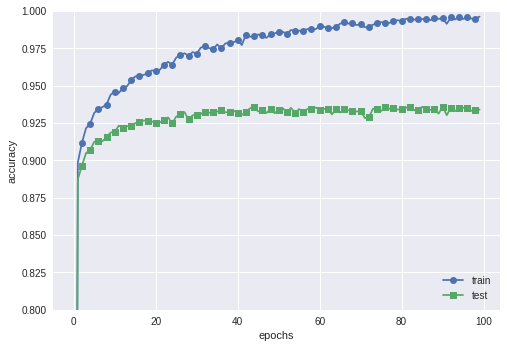

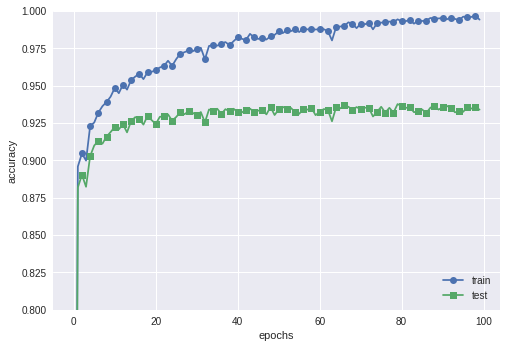

In [11]:
final = ensemble(trainer, trainer2, x_test, t_test)

# 그래프 그리기

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.8000, 1.0000)
plt.legend(loc='lower right')
plt.show()

plt.plot(x, trainer2.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer2.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.8000, 1.0000)
plt.legend(loc='lower right')
plt.show()

